In [35]:
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

## Read data as pd DataFrame

In [2]:
with open('../Astr511HW1data.dat', 'r') as ff:
    line1 = ff.readline()
    cols = line1.strip('#').split()

df = pd.read_csv('../Astr511HW1data.dat', comment='#', delim_whitespace=True, names=cols)

In [3]:
df.head()

,ra,dec,run,Ar,u,g,r,i,z,uErr,gErr,rErr,iErr,zErr,pmL,pmB,pmErr
0,181.61220,27.57260,5087,0.05,16.40,15.24,14.80,14.73,14.69,0.02,0.02,0.02,0.02,0.01,5.16,-1.45,2.72
1,181.61303,27.60770,5087,0.05,21.84,19.55,18.40,18.04,17.79,0.18,0.02,0.02,0.02,0.02,5.48,4.73,3.16
2,181.61416,27.35956,5112,0.05,19.76,17.56,16.61,16.23,16.07,0.03,0.01,0.02,0.03,0.03,3.14,7.92,2.79
3,181.61640,27.82464,5112,0.06,21.73,20.63,20.19,19.99,20.04,0.16,0.03,0.03,0.03,0.13,19.13,-1.08,5.08
4,181.62112,28.01623,5087,0.05,21.37,20.38,20.11,20.05,19.87,0.11,0.04,0.03,0.03,0.09,-3.65,-8.00,4.91


## Calculate Metalliticites Fe/H

\begin{equation}
[Fe/H] = A + Bx + Cy + Dxy + Ex^2 + Fy^2 + Gx^2y + Hxy^2 + Ix^3 + Jy^3
\end{equation}
$x = (u - g) \\
y = (g - r) \\
(A - J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20)$

In [4]:
df['x'] = df['u'] - df['g']
df['y'] = df['g'] - df['r']

coeff = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20)
A, B, C, D, E, F, G, H, I, J = coeff

metallicity = lambda x, y: A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x**2*y + H*x*y**2 + I*x**3 + J*y**3

df['Fe/H'] = -0.6
df.loc[(df['y'] < 0.6), 'Fe/H'] = metallicity(df.loc[(df['y'] < 0.6), 'x'], df.loc[(df['y'] < 0.6), 'y'])

## Calculate Absolute Mag in r from Fe/H and g - r

#### Fiducial Abs Mag in r $M^0_r$
A7
\begin{equation}
M^0_r (g - i) = -5.06 + 14.32x - 12.97x^2 + 6.127x^3 - 1.267x^4 + 0.0967x^5
\end{equation}

#### Metalicity Correction $\Delta M_r$
A2
\begin{equation}
\Delta M_r([Fe/H]) = 4.50 - 1.11 [Fe/H] - 0.18[Fe/H]^2
\end{equation}

#### Fitted Abs Mag in r $M_r$
A3
\begin{equation}
M_r(g - i, [Fe/H]) = M^0_r (g - i) + \Delta M_r([Fe/H])
\end{equation}




In [6]:
# A2
df['DelMr'] = 4.50 - 1.11 * df['Fe/H'] - 0.18 * df['Fe/H'] ** 2

# A7
fiducial_M_r = lambda x: -5.06 + 14.32*x - 12.97*x**2 + 6.127*x**3 - 1.267*x**4 + 0.0967*x**5
df['FidcMr'] = fiducial_M_r(df['g'] - df['i'])

# A3
df['Mr'] = df['FidcMr'] + df['DelMr']

## Calculate Z, distance above galactic plane

For distance from galactic plane Z

We assume 

$Z = D$

and 

$r - M_r = 5 * log(D/(10pc))$

Solving for D:

$D = 10^{0.2 * (r - M_r) + 1} pc$


In [187]:
df['Z'] = 10 ** ((df['r'] - df['Mr']) / 5) * 10  # pc
df['Z(kpc)'] = df['Z'] / 1000

## Problem 1
For stars with $0.2 < g - r < 0.4$, plot $ln(\rho)$ vs. $Z$ where $\rho$ is the stellar number density in a given bin, Approximate 

$\rho(Z) = N(Z) / V(Z)$

where N is the number of stars in a given bin, V is the bin volume.

In [191]:
gr24 = df.loc[((df['g'] - df['r']) < 0.4) & ((df['g'] - df['r']) > 0.2)]

In [186]:
sa = (314 * u.deg **2).to(u.sr).value

In [184]:
def get_vol_elements(n, bin_size, bin_start, solid_angle, method='avg', disp=False):
    def puck_vol(distance, sa, thickness):
        return sa * distance ** 2 * thickness
    def cone_vol(distance, sa):
        return 1/3 * distance ** 3 * sa 
    
    lower_bound = np.arange(bin_start, round(bin_size * n + bin_start, 6), bin_size)
    upper_bound = np.arange(bin_start + bin_size, round(bin_size * (n + 1) + bin_start, 6), bin_size)
    lower_bound = np.round(lower_bound, 6)
    upper_bound = np.round(upper_bound, 6)
    
    
    if method == 'avg':
        dVs =  0.5 * (puck_vol(lower_bound, solid_angle, bin_size) + 
                      puck_vol(upper_bound, solid_angle, bin_size))
        
    elif method == 'lower':
        dVs = puck_vol(lower_bound, solid_angle, bin_size)
            
    elif method == 'upper':
        dVs = puck_vol(upper_bound, solid_angle, bin_size)
        
    elif method == 'exact':
        dVs = cone_vol(upper_bound, solid_angle) - cone_vol(lower_bound, solid_angle)
    
    if disp:
        for ii in range(n):
            print(f'from {lower_bound[ii]} to {upper_bound[ii]}:\t {dVs[ii]}')
    
    return dVs
    
    


In [203]:
(get_vol_elements(40, 0.4, 0.8, sa, 'exact') / get_vol_elements(40, 0.4, 0.8, sa, 'avg')).mean()

0.9980937009788111

In [209]:
def get_star_counts(distance_arr, n, bin_size, bin_start, disp_table=False):
    bounds =  np.arange(bin_start, round(bin_size * (n + 1) + bin_start, 6), bin_size)
    bounds = np.round(bounds, 6)
    counts, bins = np.histogram(distance_arr, bins=bounds)
    if disp_table:
        for ii in range(n):
            print(f'from {bounds[ii]} to {bounds[ii+1]}:\t {counts[ii]}')
    return counts
    

In [210]:
get_star_counts(gr24['Z(kpc)'], 20, .4, .8, disp_table=True)

from 0.8 to 1.2:	 2102
from 1.2 to 1.6:	 3235
from 1.6 to 2.0:	 3409
from 2.0 to 2.4:	 3307
from 2.4 to 2.8:	 3194
from 2.8 to 3.2:	 2879
from 3.2 to 3.6:	 2792
from 3.6 to 4.0:	 2640
from 4.0 to 4.4:	 2657
from 4.4 to 4.8:	 2676
from 4.8 to 5.2:	 2590
from 5.2 to 5.6:	 2687
from 5.6 to 6.0:	 2713
from 6.0 to 6.4:	 2799
from 6.4 to 6.8:	 2834
from 6.8 to 7.2:	 2804
from 7.2 to 7.6:	 2942
from 7.6 to 8.0:	 2938
from 8.0 to 8.4:	 3050
from 8.4 to 8.8:	 3004


array([2102, 3235, 3409, 3307, 3194, 2879, 2792, 2640, 2657, 2676, 2590,
       2687, 2713, 2799, 2834, 2804, 2942, 2938, 3050, 3004], dtype=int64)

In [84]:
# spot check on N(4.8 < Z < 5.2)
sum((gr24['D(kpc)'] < 5.2) & (gr24['D(kpc)'] > 4.8)) 

2590

In [216]:
def plot_hist(n, bin_size, bin_start, distance_arr):
    sa = (314 * u.deg **2).to(u.sr).value
    V = get_vol_elements(n, bin_size, bin_start, sa)
    N = get_star_counts(distance_arr, n, bin_size, bin_start)
    bounds =  np.arange(bin_start, round(bin_size * n + bin_start, 6), bin_size)
    bounds = np.round(bounds, 6)    
    plt.figure()
    plt.step(bounds, np.log(N/V))
    plt.xlabel('Z (kpc)')
    plt.ylabel(r'$ln(\rho(Z))$')

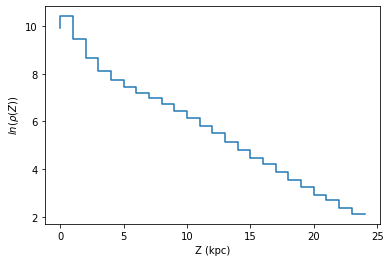

In [222]:
plot_hist(n=25, bin_size=1, bin_start=0, distance_arr=gr24['Z(kpc)'])

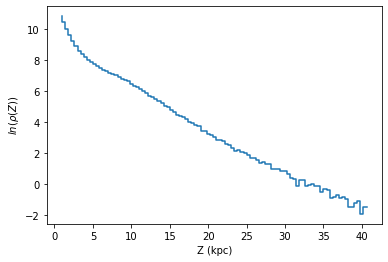

In [220]:
plot_hist(n=100, bin_size=.4, bin_start=1, distance_arr=gr24['Z(kpc)'])

In [213]:
data = Table.read('../Astr511HW1data.dat', format='ascii')

NameError: name 'Table' is not defined